In [1]:
# This notebook will 
# take in two videos, 
# get the landmarks/keypoints for each frame,
# calculate the difference between each corresponding pair
# calculate the mean square error for all of them

# This notebook will also display two videos side by side with a graph of the keypoint error differences.

In [264]:
import moviepy
from moviepy.editor import *
import pygame
from moviepy.decorators import apply_to_audio, apply_to_mask
from moviepy.editor import VideoFileClip, vfx

from matplotlib import pyplot as plt
import mediapipe as mp
from urllib import request
import os
import pathlib
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
import math

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

plt.rcParams.update({'font.size': 26})

In [26]:
WORKING_DIR = pathlib.Path().resolve()
WORKING_DIR

WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021')

In [18]:
def flip_video_horizontally(video_dir):
    """flips video horizontally, resaves same name"""
    
    split = video_dir.split("/")
    fnamesplit = split[-1].split(".")
    new_fname = fnamesplit[0]+"_reversed.mp4"
    new_dir = "/".join(split[:-1])+"/"+new_fname
    print(new_dir)
    
    clip = VideoFileClip(video_dir)
    reversed_clip = clip.fx(vfx.mirror_x)
    reversed_clip.write_videofile(new_dir)

In [19]:
def get_input_filenames(name, base_names):
    """appends the name of the person onto the base file name for poses"""
    new_frames_fnames = []

    for fname in base_names:
        splitname = fname.split(".")
        splitname[0] += ("_"+ name)
        new_name = ".".join(splitname)
        if str(1) in new_name or str(2) in new_name or str(3) in new_name:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_1_3")
            full_path = Path.joinpath(video_path, new_name)
        else:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_4_6")
            full_path = Path.joinpath(video_path, new_name)
            
        new_frames_fnames.append(full_path)

    return new_frames_fnames

In [301]:
def get_filenames():

    teacher_video_fnames = ["pose_1.mp4", "pose_2.mp4", "pose_3.mp4",
                            "pose_4.mp4", "pose_5.mp4", "pose_6.mp4"]
    
    #teacher_video_fpaths = [Path("pose_1_3/pose_1.mp4"), Path("pose_1_3/pose_2.mp4"), Path("pose_1_3/pose_3.mp4"),
    #                       Path("pose_4_6/pose_4.mp4"), Path("pose_4_6/pose_5.mp4"), Path("pose_4_6/pose_6.mp4")]
    teacher_video_fpaths = []
    
    for x in teacher_video_fnames:
        if str(1) in x or str(2) in x or str(3) in x:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_1_3")
            full_path = Path.joinpath(video_path, x)
        else:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_4_6")
            full_path = Path.joinpath(video_path, x)
        teacher_video_fpaths.append(full_path)
            

    lori_video_fnames = get_input_filenames("lori", teacher_video_fnames)

    mikaela_video_fnames = get_input_filenames("mikaela", teacher_video_fnames)

    jong_video_fnames = get_input_filenames("jong", teacher_video_fnames)

    return {"teacher": teacher_video_fpaths, 
            "lori": lori_video_fnames,
            "mikaela": mikaela_video_fnames,
            "jong": jong_video_fnames}

video_fpaths = get_filenames()

In [302]:
video_fpaths

{'teacher': [WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_1.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_2.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_3.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_4.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_5.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_6.mp4')],
 'lori': [WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_1_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_2_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_3_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documen

In [84]:
def display_two_videos(video_one, video_two):
    """Displays a video player for two videos to play side by side"""
    cap = cv2.VideoCapture(str(video_one))
    cap2 =cv2.VideoCapture(str(video_two))

    if (cap.isOpened() == False): 
        print("Error opening video stream or file")
    if (cap2.isOpened() == False): 
        print("Error opening video stream or file")

    while(cap.isOpened() or cap2.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        ret, frame1 = cap2.read()
        if ret == True:
            # Display the resulting frame
            cv2.imshow('Frame', frame)
            cv2.imshow('Frame', frame1)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        else: 
            break

    cap.release()
    cap2.release()

    cv2.destroyAllWindows()

In [86]:
#display_two_videos('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/subsample_output_1',
#                   'C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/subsample_output_2')

In [267]:
def save_two_videos_2(video_one, video_two, graph_image_name, graph_image_name2, output_name):
    """Displays a video player for two videos to play side by side"""
    
    #clip1 = get_warped_video(str(video_one), 478)
    #clip2 = get_warped_video(str(video_two), 478) 
    
    clip1 = VideoFileClip(str(video_one))
    clip2 = VideoFileClip(str(video_two))
    
    myclip = ImageClip(graph_image_name).set_duration(clip1.duration)
    myclip2 = ImageClip(graph_image_name2).set_duration(clip1.duration)
    
    clips = [[clip1, clip2],
             [myclip, myclip2]]
    
    final = clips_array(clips)
    
    final.write_videofile(output_name)

In [274]:
save_two_videos_2('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/subsample_pose_2_teacher.mp4',
                  'C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/subsample_pose_2_mikaela.mp4',
                  "pose_2_teacher_mikaela_dist.png",
                  "pose_2_teacher_mikaela_rmse.png",
                  "pose_2_teacher_mikaela.mp4")

Moviepy - Building video pose_2_teacher_mikaela.mp4.
Moviepy - Writing video pose_2_teacher_mikaela.mp4



Moviepy - Done !
Moviepy - video ready pose_2_teacher_mikaela.mp4


In [48]:
def get_num_frames_of_all_videos(video_fpaths):
    """Returns a dataframe of each pose video's number of frames.
    e.x. ['instructor', 'jong', 'lori', 'mikaela']"""
    video_frame_data = []
    
    subjects = list(video_fpaths.keys())
        
    for i in range(6):
        print(f"Processing Video {i+1}/6")
        video_dict = {}
        for subject in subjects:
            clip = VideoFileClip(str(video_fpaths[subject][i]))
            n_frames = clip.reader.nframes
            print(f"Subject: {subject} has {n_frames} frames.")
            
            video_dict[subject] = n_frames
        
        video_frame_data.append(video_dict)
    
    return pd.DataFrame(video_frame_data)

In [49]:
df = get_num_frames_of_all_videos(video_fpaths)
df

Processing Video 1/6
Subject: teacher has 478 frames.
Subject: lori has 338 frames.
Subject: mikaela has 482 frames.
Subject: jong has 310 frames.
Processing Video 2/6
Subject: teacher has 1152 frames.
Subject: lori has 314 frames.
Subject: mikaela has 804 frames.
Subject: jong has 602 frames.
Processing Video 3/6
Subject: teacher has 229 frames.
Subject: lori has 196 frames.
Subject: mikaela has 207 frames.
Subject: jong has 158 frames.
Processing Video 4/6
Subject: teacher has 379 frames.
Subject: lori has 165 frames.
Subject: mikaela has 275 frames.
Subject: jong has 290 frames.
Processing Video 5/6
Subject: teacher has 370 frames.
Subject: lori has 220 frames.
Subject: mikaela has 380 frames.
Subject: jong has 181 frames.
Processing Video 6/6
Subject: teacher has 487 frames.
Subject: lori has 295 frames.
Subject: mikaela has 306 frames.
Subject: jong has 470 frames.


teacher  lori  mikaela  jong
0      478   338      482   310
1     1152   314      804   602
2      229   196      207   158
3      379   165      275   290
4      370   220      380   181
5      487   295      306   470

In [113]:
def get_sampled_frames(input_video, every_nth_percentage = .05):
    """returns a list of frames sampled at every nth percentage frame number of the whole clip"""
    
    clip = VideoFileClip(input_video)
    n_frames = clip.reader.nframes
    
    frames_list = []
    
    for frame_num in range(1, n_frames, math.floor(n_frames * every_nth_percentage)):
        
        frame = clip.get_frame(frame_num / clip.fps)
        
        frames_list.append(frame)
        
        # showing the frame with the help of matplotlib
        #plt.imshow(frame, interpolation ='nearest')
        # show
        #plt.show()
    return frames_list

In [105]:
def get_warped_video(input_video, end_time):
    """gets a video and warps it to be the length of end_time"""
    clip = VideoFileClip(input_video)
    n_frames = sum(1 for x in clip.iter_frames())
    print(n_frames)
    
    new_video = moviepy.video.fx.all.speedx(clip, factor = None , final_duration=end_time)
    print(new_video.duration)
    
    return new_video

In [124]:
frames = get_sampled_frames(str(video_fpaths["teacher"][0]))

In [ ]:
frames_2 = get_sampled_frames(str(video_fpaths["teacher"][0]))

In [125]:
len(frames)

21

<class 'numpy.ndarray'>


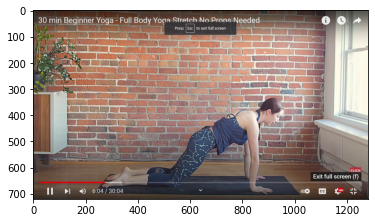

<class 'numpy.ndarray'>


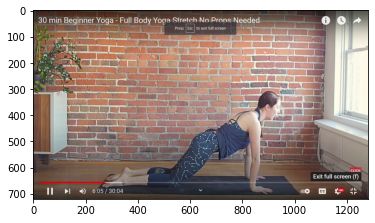

<class 'numpy.ndarray'>


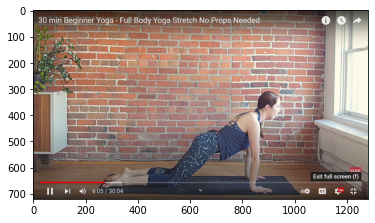

<class 'numpy.ndarray'>


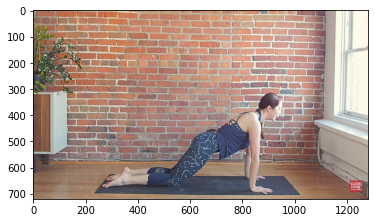

<class 'numpy.ndarray'>


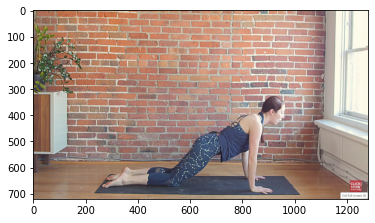

<class 'numpy.ndarray'>


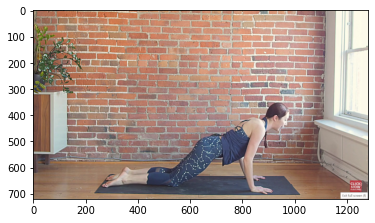

<class 'numpy.ndarray'>


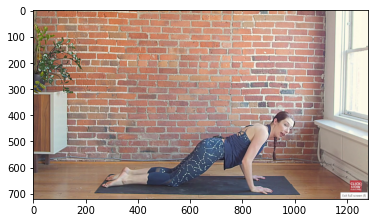

<class 'numpy.ndarray'>


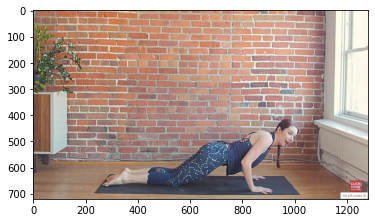

<class 'numpy.ndarray'>


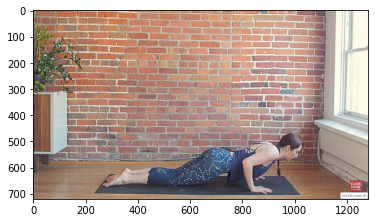

<class 'numpy.ndarray'>


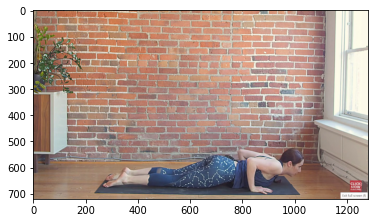

<class 'numpy.ndarray'>


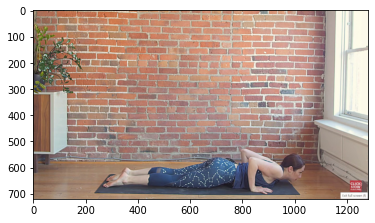

<class 'numpy.ndarray'>


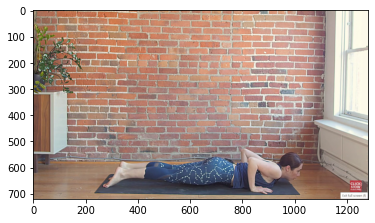

<class 'numpy.ndarray'>


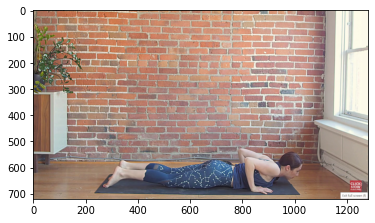

<class 'numpy.ndarray'>


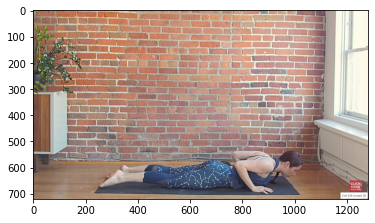

<class 'numpy.ndarray'>


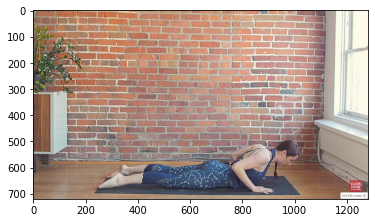

<class 'numpy.ndarray'>


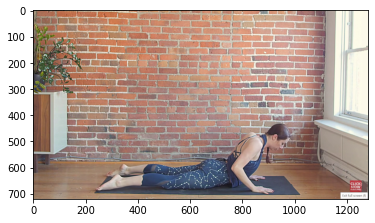

<class 'numpy.ndarray'>


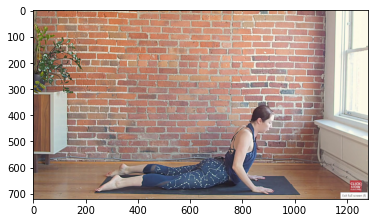

<class 'numpy.ndarray'>


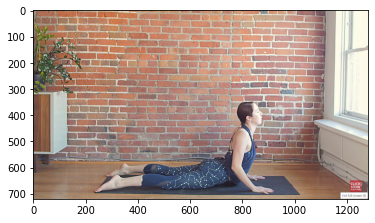

<class 'numpy.ndarray'>


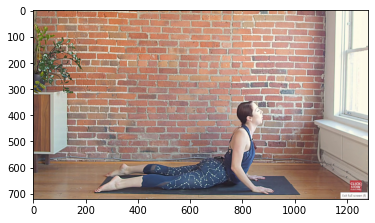

<class 'numpy.ndarray'>


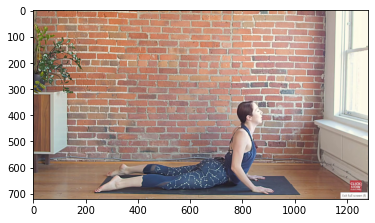

<class 'numpy.ndarray'>


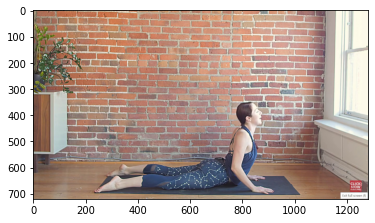

In [126]:
for img in frames:
    print(type(img))
    plt.imshow(img)
    plt.show()

In [291]:
def make_video_sequence(image_list, file_name):
    """returns a clip made from a list of images"""

    height, width, layers = image_list[0].shape
    
    out = cv2.VideoWriter(file_name, 0, 10, (width, height))
    for img in image_list:
        img2  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        out.write(img2)
    out.release()

In [99]:
make_video_sequence(landmark_frames, "landmarks.mp4")

In [292]:
def get_landmarks(frames_list):
    """returns a dictionary of {frame_num: {landmark 1: [x, y, z]}...} 33 coordinates of an input video
       for every frame number in the frames_list.
       and returns the frames_list with the landmarks attached"""
    
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.2, model_complexity=2) as pose:
        frame_landmarks = []
        landmark_frames = []
        for i, img in enumerate(frames_list):
            img2 = img
            results = pose.process(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            mp_drawing.draw_landmarks(
                image=img2,
                landmark_list=results.pose_landmarks,
                connections=mp_pose.POSE_CONNECTIONS)

            landmark_frames.append(img2)

            landmarks = {}
            for j, lmk in enumerate(results.pose_landmarks.landmark):
                landmarks[f"Landmark_{j+1}_X"] = float(lmk.x)
                landmarks[f"Landmark_{j+1}_Y"] = float(lmk.y)
                landmarks[f"Landmark_{j+1}_Z"] = float(lmk.z)

            frame_landmarks.append(landmarks)
        
    return pd.DataFrame(frame_landmarks), landmark_frames

In [127]:
df, landmark_frames = get_landmarks(frames)
df

Landmark_1_X  Landmark_1_Y  Landmark_1_Z  Landmark_2_X  Landmark_2_Y  \
0       0.726829      0.592439     -0.027226      0.728400      0.570593   
1       0.728568      0.551802      0.000326      0.727063      0.527446   
2       0.728993      0.542950      0.007232      0.724580      0.518307   
3       0.732258      0.551526      0.014024      0.730480      0.524948   
4       0.740935      0.574074      0.018202      0.738371      0.550409   
5       0.745084      0.608300      0.046643      0.744749      0.583546   
6       0.760731      0.656869     -0.087989      0.765495      0.634610   
7       0.775538      0.705664     -0.007486      0.778675      0.683780   
8       0.786209      0.778918     -0.008255      0.787725      0.752701   
9       0.787801      0.854920      0.032209      0.789808      0.833108   
10      0.790070      0.882721      0.009981      0.792067      0.861633   
11      0.784218      0.869585      0.021116      0.785881      0.845423   
12      0.781577      0.869437      0.017948      0.784678      0.847909   
13      0.770363      0.877018     -0.069358      0.775102      0.856876   
14      0.760393      0.813855     -0.053528      0.765652      0.792951   
15      0.748884      0.720865     -0.038011      0.750780      0.695927   
16      0.712600      0.610349     -0.038802      0.710839      0.591440   
17      0.680650      0.550263     -0.091585      0.671411      0.535746   
18      0.680954      0.545453     -0.106033      0.672037      0.532576   
19      0.681276      0.540394     -0.142819      0.671080      0.529287   
20      0.679951      0.557086     -0.142236      0.672602      0.543320   

    Landmark_2_Z  Landmark_3_X  Landmark_3_Y  Landmark_3_Z  Landmark_4_X  ...  \
0      -0.017227      0.726735      0.567102     -0.017412      0.724910  ...   
1       0.010097      0.724899      0.525403      0.009875      0.722697  ...   
2       0.018381      0.722492      0.517223      0.018138      0.720569  ...   
3       0.024301      0.728479      0.523118      0.024076      0.726579  ...   
4       0.029283      0.736334      0.548377      0.029043      0.734203  ...   
5       0.059668      0.743154      0.580631      0.059433      0.741615  ...   
6      -0.062986      0.765772      0.634778     -0.063219      0.766196  ...   
7       0.011030      0.778407      0.681956      0.010775      0.778299  ...   
8       0.008787      0.785831      0.749381      0.008548      0.783934  ...   
9       0.045975      0.788347      0.830738      0.045785      0.786839  ...   
10      0.026474      0.791024      0.859216      0.026260      0.789874  ...   
11      0.038916      0.785224      0.843266      0.038657      0.784401  ...   
12      0.034426      0.783964      0.845307      0.034192      0.783039  ...   
13     -0.055967      0.774870      0.852911     -0.056215      0.774426  ...   
14     -0.043277      0.765097      0.788256     -0.043534      0.764369  ...   
15     -0.025471      0.749404      0.693144     -0.025715      0.747803  ...   
16     -0.025373      0.709184      0.590015     -0.025534      0.707348  ...   
17     -0.076972      0.669317      0.536156     -0.077223      0.667242  ...   
18     -0.092043      0.670365      0.533069     -0.092338      0.668611  ...   
19     -0.128806      0.669064      0.530130     -0.129106      0.667011  ...   
20     -0.132416      0.670994      0.543945     -0.132646      0.669151  ...   

    Landmark_30_Z  Landmark_31_X  Landmark_31_Y  Landmark_31_Z  Landmark_32_X  \
0        0.211867       0.274753       0.858950      -0.062016       0.261430   
1        0.209823       0.272433       0.865532      -0.066168       0.234171   
2        0.186721       0.271297       0.859216      -0.069553       0.227252   
3        0.213751       0.270131       0.864420      -0.069696       0.227395   
4        0.193491       0.268893       0.865554      -0.082559       0.225771   
5        0.189966       0.268346       0.860835      -0.101292

In [175]:
df.columns

Index(['Landmark_1_X', 'Landmark_1_Y', 'Landmark_1_Z', 'Landmark_2_X',
       'Landmark_2_Y', 'Landmark_2_Z', 'Landmark_3_X', 'Landmark_3_Y',
       'Landmark_3_Z', 'Landmark_4_X', 'Landmark_4_Y', 'Landmark_4_Z',
       'Landmark_5_X', 'Landmark_5_Y', 'Landmark_5_Z', 'Landmark_6_X',
       'Landmark_6_Y', 'Landmark_6_Z', 'Landmark_7_X', 'Landmark_7_Y',
       'Landmark_7_Z', 'Landmark_8_X', 'Landmark_8_Y', 'Landmark_8_Z',
       'Landmark_9_X', 'Landmark_9_Y', 'Landmark_9_Z', 'Landmark_10_X',
       'Landmark_10_Y', 'Landmark_10_Z', 'Landmark_11_X', 'Landmark_11_Y',
       'Landmark_11_Z', 'Landmark_12_X', 'Landmark_12_Y', 'Landmark_12_Z',
       'Landmark_13_X', 'Landmark_13_Y', 'Landmark_13_Z', 'Landmark_14_X',
       'Landmark_14_Y', 'Landmark_14_Z', 'Landmark_15_X', 'Landmark_15_Y',
       'Landmark_15_Z', 'Landmark_16_X', 'Landmark_16_Y', 'Landmark_16_Z',
       'Landmark_17_X', 'Landmark_17_Y', 'Landmark_17_Z', 'Landmark_18_X',
       'Landmark_18_Y', 'Landmark_18_Z', 'Landmark_1

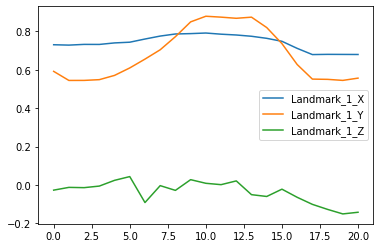

In [100]:
df[['Landmark_1_X', 'Landmark_1_Y', 'Landmark_1_Z']].plot.line()
plt.show()

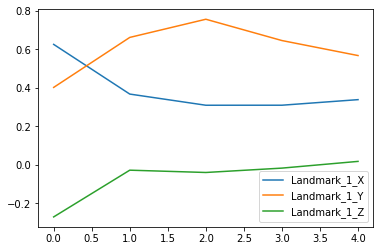

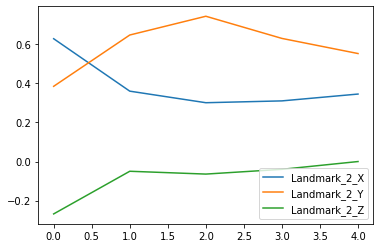

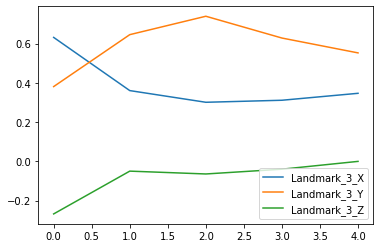

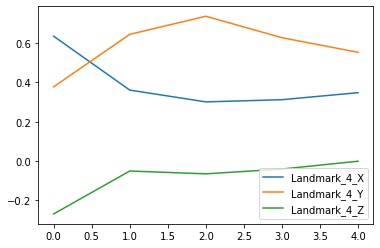

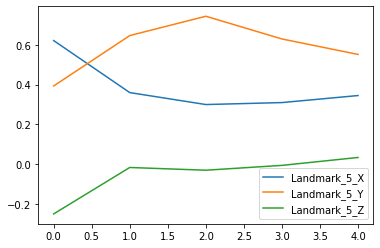

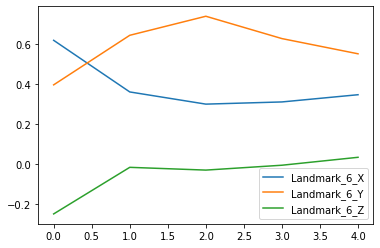

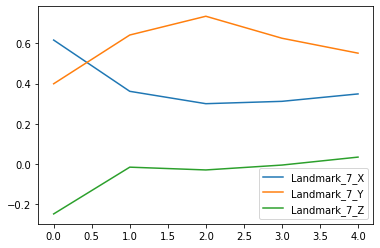

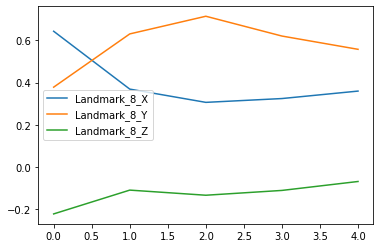

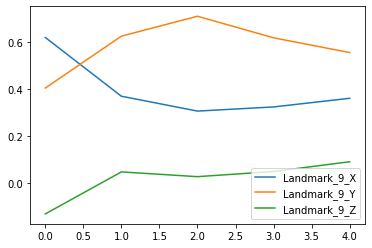

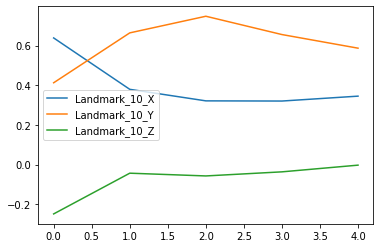

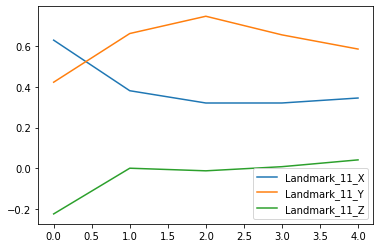

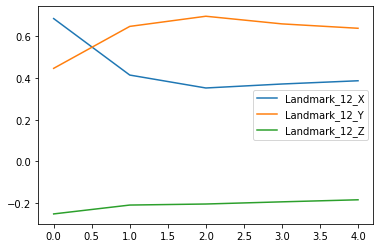

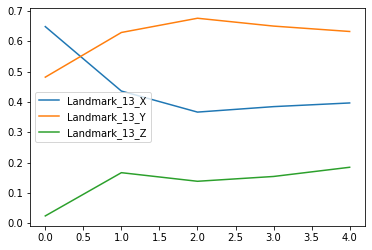

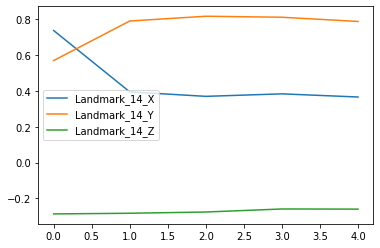

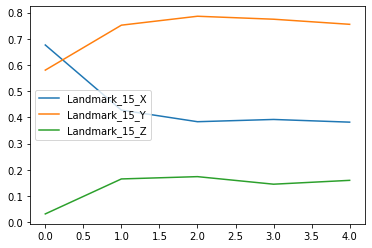

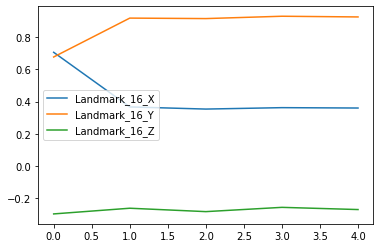

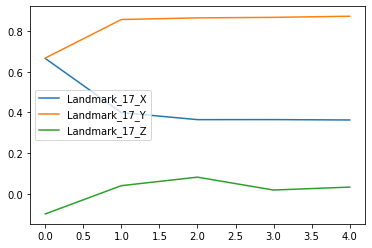

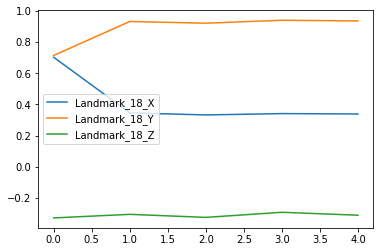

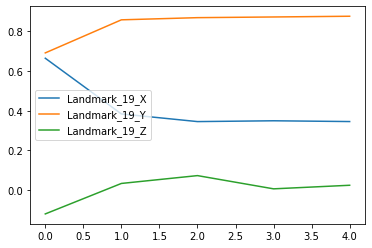

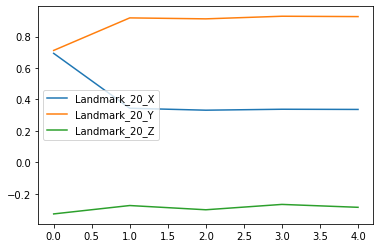

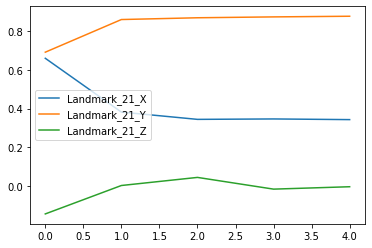

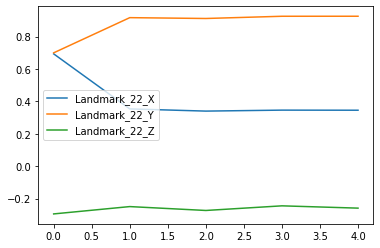

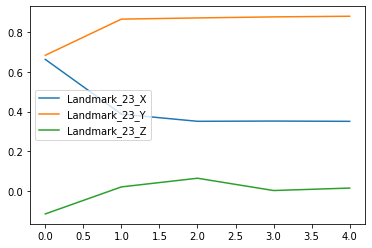

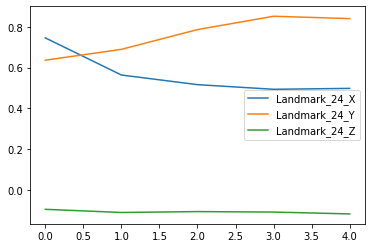

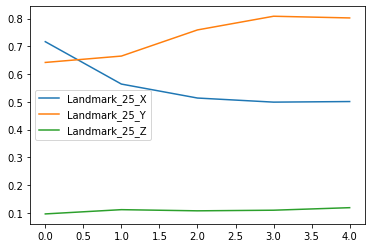

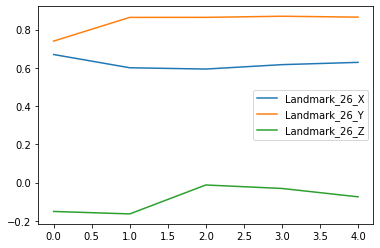

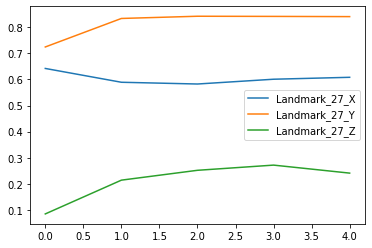

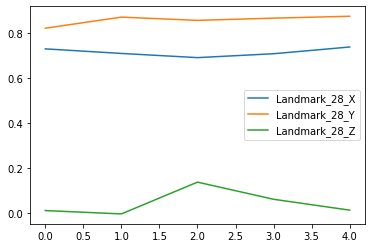

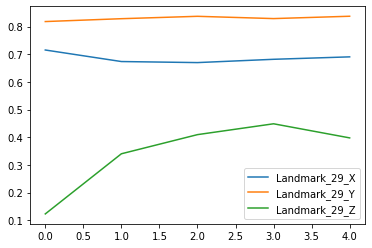

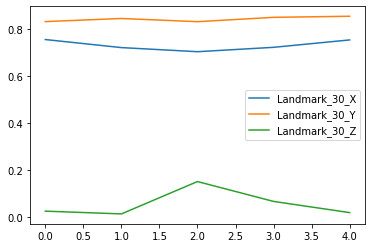

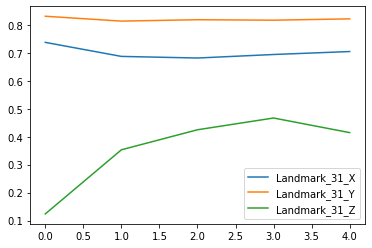

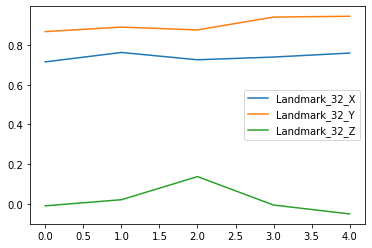

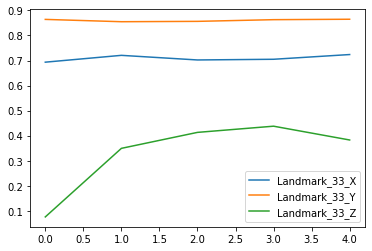

In [185]:
cols = df.columns
for i in range(0, 97, 3):
    df[[cols[i], cols[i+1], cols[i+2]]].plot.line()

In [104]:
#get_landmarks_video(str(video_fpaths["teacher"][0]), .25)

In [101]:
#warped = get_warped_video(str(video_fpaths["lori"][0]), 478)

In [293]:
def get_2_videos_frames(vid_1, vid_2, sample_rate = .05):
    video_1 = get_sampled_frames(vid_1, sample_rate)
    video_2 = get_sampled_frames(vid_2, sample_rate)
    
    truncate_val = max([len(video_1), len(video_2)])
    
    return video_1[:truncate_val], video_2[:truncate_val]

In [133]:
vid1, vid2 = get_2_videos_frames(str(video_fpaths["teacher"][2]),
                                 str(video_fpaths["mikaela"][2]))

In [135]:
df_1, landmark_frames_1 = get_landmarks(vid1)

In [134]:
df_2, landmark_frames_2 = get_landmarks(vid2)

In [233]:
make_video_sequence(landmark_frames_1, "pose_2_teacher.mp4")

In [234]:
make_video_sequence(landmark_frames_2, "pose_2_mikaela.mp4")

In [141]:
df_1

Landmark_1_X  Landmark_1_Y  Landmark_1_Z  Landmark_2_X  Landmark_2_Y  \
0       0.721052      0.814843      0.030635      0.729482      0.829430   
1       0.725056      0.816647      0.014613      0.732882      0.834258   
2       0.723054      0.815768     -0.014807      0.730398      0.832141   
3       0.445934      0.694962     -0.244529      0.447523      0.681294   
4       0.492433      0.687105     -0.215227      0.495895      0.672092   
5       0.719963      0.806910     -0.083465      0.728880      0.821511   
6       0.717182      0.800042     -0.064023      0.728554      0.819479   
7       0.716908      0.801143     -0.051159      0.727900      0.820996   
8       0.718370      0.805116     -0.049538      0.728810      0.823940   
9       0.717724      0.801477     -0.071049      0.728122      0.821472   
10      0.719186      0.811510     -0.057666      0.728237      0.830413   
11      0.717758      0.807868     -0.032214      0.727824      0.824281   
12      0.718063      0.809279     -0.069344      0.728219      0.825925   
13      0.708958      0.830852     -0.146230      0.719493      0.846319   
14      0.710029      0.836280     -0.162955      0.719595      0.855838   
15      0.706636      0.825163     -0.112674      0.718596      0.838417   
16      0.712029      0.813732     -0.053247      0.721726      0.830042   
17      0.695068      0.867139      0.029081      0.698061      0.864281   
18      0.736655      0.871108      0.140231      0.737816      0.866642   
19      0.572502      0.770155      0.061372      0.571662      0.764979   
20      0.706338      0.817177     -0.051520      0.713830      0.828277   

    Landmark_2_Z  Landmark_3_X  Landmark_3_Y  Landmark_3_Z  Landmark_4_X  ...  \
0       0.014832      0.729199      0.833903      0.014664      0.728871  ...   
1      -0.000396      0.732379      0.838612     -0.000563      0.731785  ...   
2      -0.035948      0.730151      0.835759     -0.036157      0.729895  ...   
3      -0.250436      0.448698      0.680023     -0.250611      0.449982  ...   
4      -0.209779      0.498078      0.672473     -0.209960      0.500306  ...   
5      -0.103135      0.728655      0.824946     -0.103402      0.728307  ...   
6      -0.083166      0.728496      0.823443     -0.083429      0.728349  ...   
7      -0.072430      0.727643      0.824966     -0.072707      0.727354  ...   
8      -0.069833      0.728579      0.827365     -0.070096      0.728316  ...   
9      -0.092811      0.727818      0.825629     -0.093100      0.727455  ...   
10     -0.077207      0.727670      0.834150     -0.077418      0.727025  ...   
11     -0.054258      0.727275      0.827642     -0.054493      0.726652  ...   
12     -0.089151      0.727850      0.829570     -0.089406      0.727497  ...   
13     -0.150427      0.718972      0.852484     -0.150599      0.718384  ...   
14     -0.170105      0.718773      0.863756     -0.170378      0.717123  ...   
15     -0.122773      0.718674      0.844152     -0.122875      0.718346  ...   
16     -0.068491      0.721352      0.833879     -0.068624      0.720819  ...   
17      0.032288      0.698191      0.864609      0.032194      0.698160  ...   
18      0.148441      0.737114      0.865808      0.148368      0.736227  ...   
19      0.059518      0.571755      0.765885      0.059370      0.572040  ...   
20     -0.066793      0.713434      0.830544     -0.066916      0.713557  ...   

    Landmark_30_Z  Landmark_31_X  Landmark_31_Y  Landmark_31_Z  Landmark_32_X  \
0        0.003463       0.394271       0.885523       0.177143       0.332354   
1       -0.003576       0.417078       0.892176       0.162431       0.334417   
2       -0.004134       0.419829       0.890280       0.164339       0.334714   
3        0.106380       0.424824       0.878102       0.145188       0.486714   
4        0.112012       0.411220       0.897860      -0.077058       0.519167   
5        0.007152       0.467651       0.745036       0.118408

In [272]:
def graph_rmse(video_keypoints_1, video_keypoints_2, figure_name):
    """takes in two dictionaries with the {frame_num: [x, y, z...]}
    and graphs the rmse at each frame"""
    
    df_diff = np.sqrt(((df_1 - df_2) ** 2))
    
    df_diff["mean"] = df.mean(axis=1)
    
    print(df_diff["mean"].values)
    
    plt.style.use("dark_background")
    
    plt.figure(figsize=(20,12))
    plt.plot(range(0, len(df_diff)), df_diff["mean"])
    plt.ylim(0,1)
    plt.xticks(np.arange(0, len(df_diff)))
    plt.yticks(np.arange(0, 1, step=.2))
    plt.xlabel("Frame Number")
    plt.ylabel("Average RMSE")
    plt.title("Average RMSE of all 33 Keypoints at each Frame")
    plt.savefig(figure_name)
    plt.show()
    
    #cols = df_diff.columns
    #for i in range(0, 97, 3):
    #    df_diff[[cols[i], cols[i+1], cols[i+2]]].plot.line()
    #plt.show()

In [270]:
def calculate_euclidean_dist(df_1, df_2, figure_name):
    """calculates euclidean distance of all keypoints at each frame and graphs it"""
    df_diff = np.sqrt(((df_1 - df_2) ** 2))
    cols = df_1.columns
    
    frame_dists = []
    for frame in range(0, len(df_1)):
        sum_dist = 0
        for i in range(0, 97, 3):
            base_coords = df_1[[cols[i], cols[i+1], cols[i+2]]].loc[frame].values
            target_coords = df_2[[cols[i], cols[i+1], cols[i+2]]].loc[frame].values
            # print(base_coords, target_coords)
            sum_dist += np.linalg.norm(base_coords-target_coords)
        frame_dists.append( round((sum_dist / (len(cols) / 3)), 4) )
        
    plt.style.use("dark_background")
    
    plt.figure(figsize=(20,12))
    plt.plot(range(0, len(frame_dists)), frame_dists)
    plt.ylim(0,1)
    plt.xticks(np.arange(0, len(frame_dists)))
    plt.yticks(np.arange(0, 1, step=.2))
    plt.xlabel("Frame Number")
    plt.ylabel("Euclidean Distance of Keypoints")
    plt.title("Euclidean Distance of Keypoints Over Time at Each Frame")
    plt.savefig(figure_name)
    plt.show()
    
    #return frame_dists

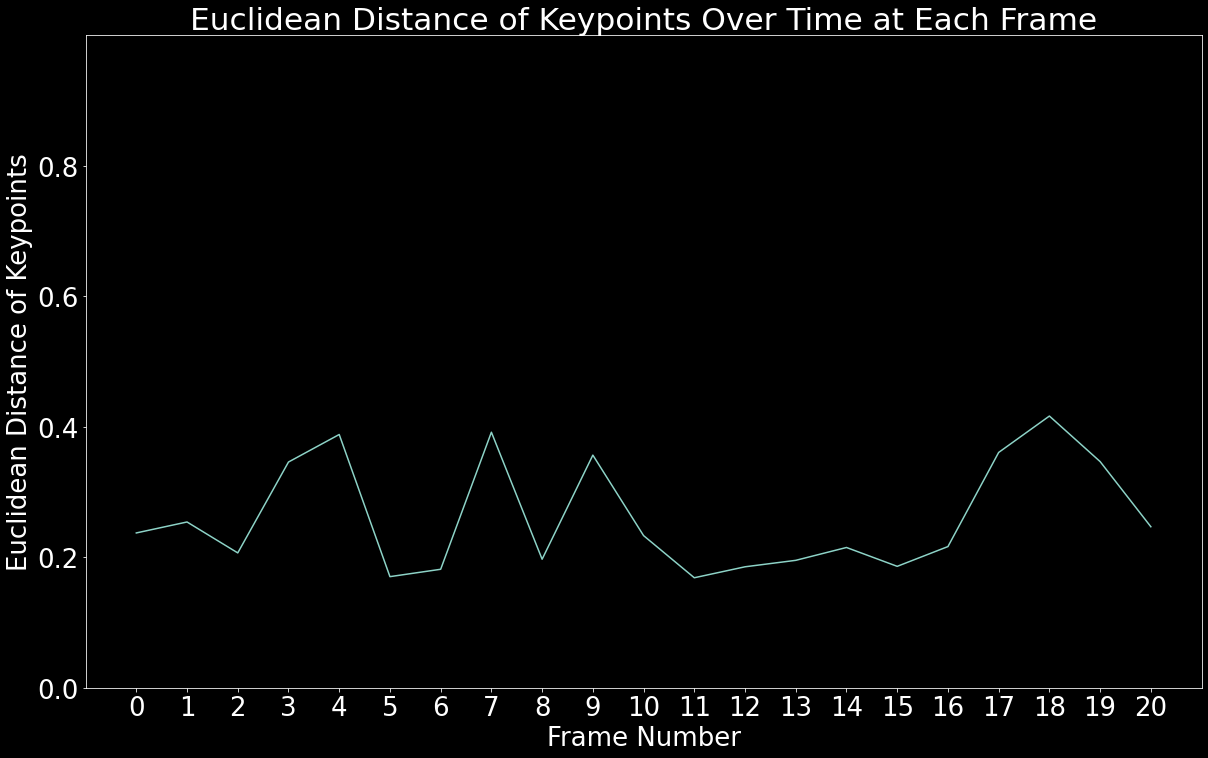

In [271]:
calculate_euclidean_dist(df_1, df_2, "pose_2_teacher_mikaela_dist.png")

[0.43786781 0.43944273 0.43769798 0.44301174 0.44650823 0.45593691
 0.4471062  0.46372979 0.4741029  0.48763587 0.48639126 0.48053247
 0.4778848  0.48947316 0.48041211 0.46619336 0.43957294 0.43888142
 0.45495598 0.45230375 0.46037616]


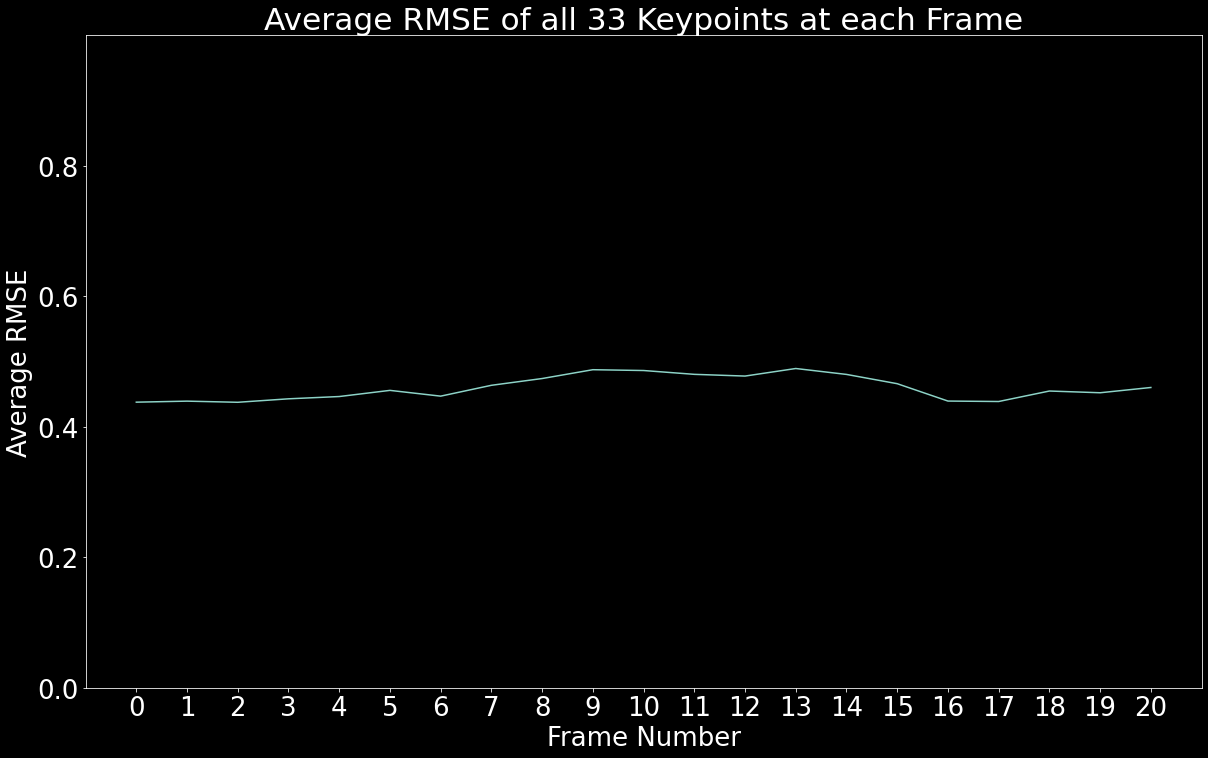

In [273]:
graph_rmse(df_1, df_2, "pose_2_teacher_mikaela_rmse.png")

In [297]:
def build_compare_video(video_1, video_2, pose_name, subject_name, sample_rate=.05):
    """gets two videos, samples them to 10% of frames, truncates to shorter length,
       gets the landmark dataframes, gets the rmse graph, builds the appended video"""
    
    # working_path 
    working_path = Path.joinpath(pathlib.Path().resolve(), "video_comparisons")
    
    # file names
    sampled_video_1_name = Path.joinpath(working_path, f"{pose_name}_teacher_sampled_video.mp4")
    sampled_video_2_name = Path.joinpath(working_path, f"{pose_name}_{subject_name}_sampled_video.mp4")
    
    rmse_graph_name      = Path.joinpath(working_path, f"{pose_name}_teacher_vs_{subject_name}_rmse.png")
    euclidist_graph_name = Path.joinpath(working_path, f"{pose_name}_teacher_vs_{subject_name}_eucldist.png")
    
    final_video_name     = Path.joinpath(working_path, f"{pose_name}_teacher_vs_{subject_name}_comparison.mp4")
    
    
    # get two videos frames
    vid1, vid2 = get_2_videos_frames(video_1, video_2, sample_rate)
    
    # get landmarks for each
    df_1, landmark_frames_1 = get_landmarks(vid1)
    df_2, landmark_frames_2 = get_landmarks(vid2)
    
    # make a video for each
    make_video_sequence(landmark_frames_1, str(sampled_video_1_name))
    make_video_sequence(landmark_frames_2, str(sampled_video_2_name))
    
    # make rmse graph
    graph_rmse(df_1, df_2, str(rmse_graph_name))
    
    # make euclidean distance graph
    calculate_euclidean_dist(df_1, df_2, str(euclidist_graph_name))
    
    # make final video
    save_two_videos_2(sampled_video_1_name,
                      sampled_video_2_name,
                      str(euclidist_graph_name),
                      str(rmse_graph_name),
                      str(final_video_name))
    

[0.43786781 0.43944273 0.43769798 0.44301174 0.44650823 0.45593691
 0.4471062  0.46372979 0.4741029  0.48763587 0.48639126 0.48053247
 0.4778848  0.48947316 0.48041211 0.46619336 0.43957294 0.43888142
 0.45495598 0.45230375 0.46037616]


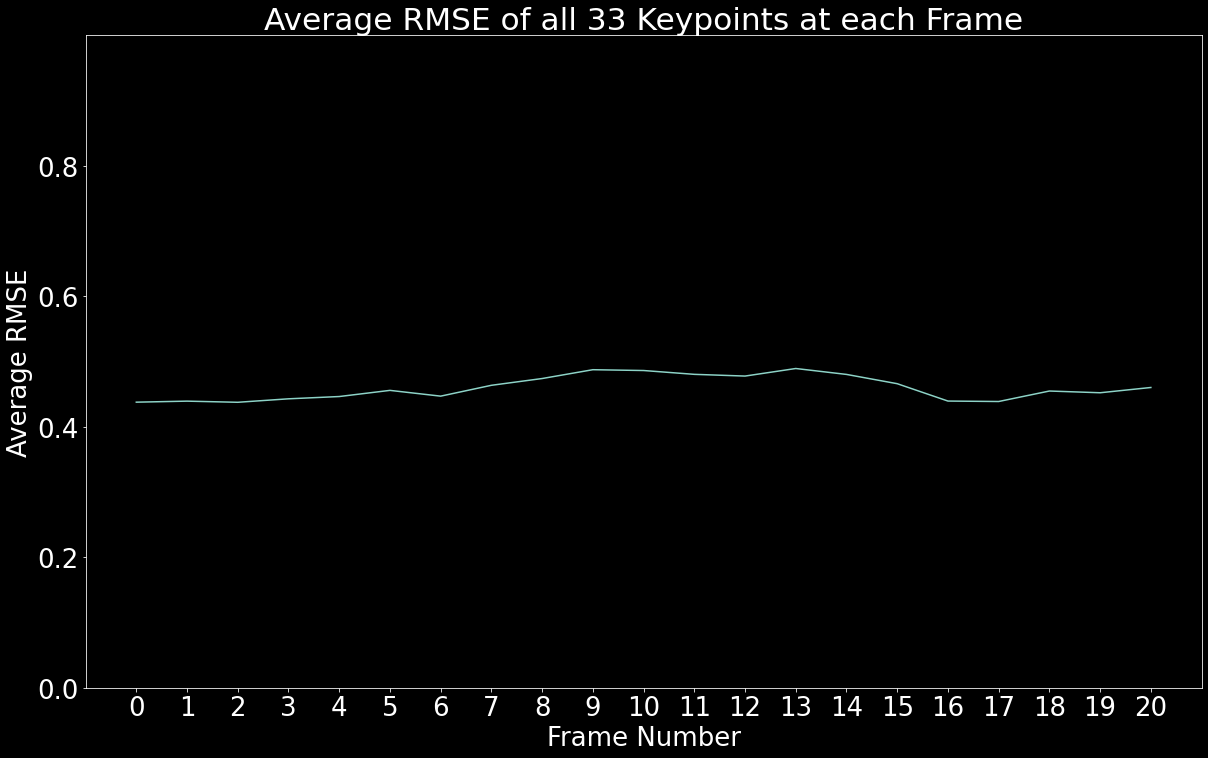

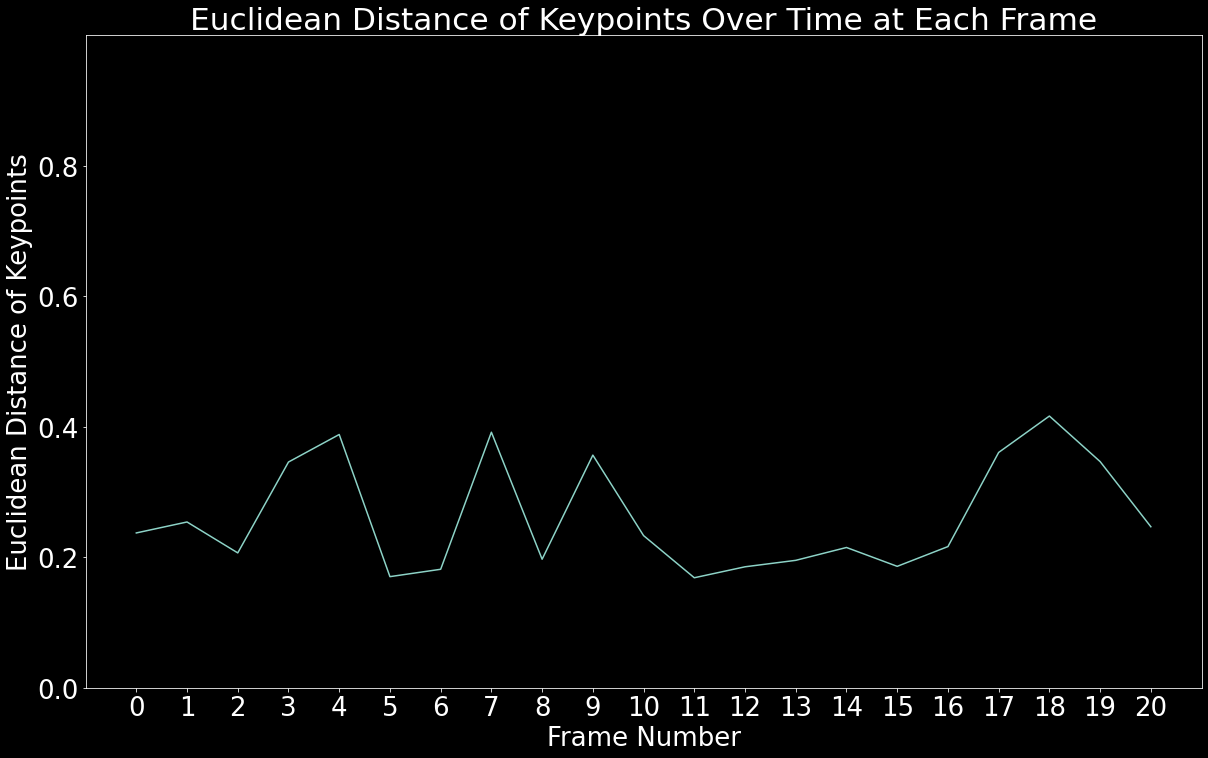

Moviepy - Building video C:\Users\Cooper\Documents\GitHub\feature_engineering_project2021\video_comparisons\pose_3_teacher_vs_mikaela_comparison.mp4.
Moviepy - Writing video C:\Users\Cooper\Documents\GitHub\feature_engineering_project2021\video_comparisons\pose_3_teacher_vs_mikaela_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Cooper\Documents\GitHub\feature_engineering_project2021\video_comparisons\pose_3_teacher_vs_mikaela_comparison.mp4


In [300]:
build_compare_video(str(video_fpaths["teacher"][2]),
                    str(video_fpaths["mikaela"][2]),
                   "pose_3",
                   "mikaela",
                   sample_rate=.05)

In [311]:
def build_all_comparisons(video_fpaths):
    """builds an output video for all comparisons"""
    
    for i in range(5, 6):
        for student in list(video_fpaths.keys())[1:]:
            teacher_video = str(video_fpaths["teacher"][i])
            student_video = str(video_fpaths[student][i])
            pose = f"pose_{i+1}"
            sample_rate = .05
        
        
            build_compare_video(teacher_video,
                                student_video,
                                pose,
                                student,
                                sample_rate=sample_rate)

In [ ]:
build_all_comparisons(video_fpaths)

In [310]:
video_fpaths

{'teacher': [WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_1.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_2.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_3.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_4.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_5.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_6.mp4')],
 'lori': [WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_1_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_2_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_3_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documen